## Assignment 4

### Machine Learning Applications, Fall 2019

#### Team: Artificial Avayans
#### Student Name/Number:
* Michel Danjou        - 18263461
* Evan Tummons         - 18215378
* Chelliah Kanthanatan - 18263003
* Gerry Carty          - 18217249

## Summary
We worked on 5 approaches:
 1.	Tune baseline model
 2.	GP model - PyMC3
 3.	GP Regression model - GPy
 4.	Different GP Regression models on periodic / non-periodic - GPy 
 5.	GP Classification model - GPy

The notebook is laid out in the order described above as this is the order in which we approached the problem.
We tested the PyMC3 and GPy models on both toy examples and got the expected result. The GP models worked especially well on example 2 and found that it is not increasing unlike the original baseline model.

Using the PyMC3 implementation of GP we employed the ExpQuad, Linear, Polynomial and Periodic kernels.  Removing the periodic kernel for prediction, in a similar way to the baseline model, we achieved a score of 68.8%.  However, we found samples failed due to mathematical instability.  For that reason, we moved to GPy.

We found GPy to be stable.  We worked on GPy Regression and initially used a similar method as PyMC3 employing the RBF, Polynomial, Linear and Periodic kernels.  Removing Periodic from predictions improved the score.  We used several optimisers, combinations of kernels and introduced the Matern32 kernel to tune our solution.

We implemented isPeriodic() function to differentiate periodic and non-periodic samples. This uses stattools method acf() to find the data mean and variance and calculate the coefficients for correlation. 

Using isPeriodic to first split samples and then predict with our GPy Regression model we achieved an accuracy of 68%.

Using our best GPy Regression model without splitting we achieved a score of 74.66%.

In team discussions we came to a realisation that maybe we missed something obvious, that this is a classification problem.  Therefore, we move to the GPy classification implementation.  Again, we worked though different optimisation approaches and eventually achieved a score of 93.5%.




In [2]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import GPy as GPy

## Baseline Model

In [3]:
#define  basis functions
def make_basis(x):
    # the components are 1,x, cos(2 \pi x), sin(2 \pi x)...
    periodic = np.hstack([np.cos(2*np.pi*x),np.sin(2*np.pi*x),np.cos(4*np.pi*x),np.sin(4*np.pi*x),np.cos(6*np.pi*x),np.sin(6*np.pi*x),np.cos(8*np.pi*x),np.sin(8*np.pi*x),np.cos(10*np.pi*x),np.sin(10*np.pi*x),np.cos(12*np.pi*x),np.sin(12*np.pi*x)])
    return np.hstack([np.ones((x.shape[0],1)),x, periodic ]) 

#  periodic basis starts at column:
col_per = 2

#baseline model
def run_model(x,y,plot=False):    
    H = make_basis(x.reshape(-1,1))
    #normalize the data
    yn = (y-np.mean(y))/np.std(y)
    
    #select non periodic components of the basis
    H_np = H[:,0:col_per]

    with pm.Model() as model:
        #prior
        w = pm.Normal('weights', mu=0, sd=50, shape=(H.shape[1],))
        sigma = pm.HalfCauchy('sigma', 5)

        #linear model
        mu = pm.Deterministic('mu', pm.math.matrix_dot(H,w).T)

        #likelihood
        y_obs = pm.Normal('y', mu=mu, sd=sigma, observed=yn)

        #we can do  an approximated inference
    with model:
        inference = pm.ADVI()
        approx = pm.fit(60000, method=inference)
        
    posterior = approx.sample(draws=500)
    
    
    all_prediction = np.dot(H,posterior['weights'].T).T

    non_periodic_prediction = np.dot(H_np,posterior['weights'][:,0:col_per].T).T
    
    if plot==True:
        plt.figure()
        plt.plot(x,np.mean(all_prediction,axis=0),'r', label='Overall Mean')
        plt.plot(x,np.mean(non_periodic_prediction,axis=0),'b', label='Mean of the non-periodic comp.')
        plt.legend()
        plt.scatter(x,yn)
    Gradients = []
    for i in range(non_periodic_prediction.shape[0]):
        Gradients.append(np.min(np.gradient(non_periodic_prediction[i,:], x)))
        
    posterior_probability_deriviative_is_positive = len(np.where(np.array(Gradients)>0)[0])/len(Gradients)
    print("probability that the function is increasing=", posterior_probability_deriviative_is_positive)
    if posterior_probability_deriviative_is_positive>0.95:
        return 1
    else:
        return 0

    
#this is the inpu
x = np.linspace(0,1,100)    

## FIRST APPROACH - GP Model using Pymc3
### Include Generic, Linear, Polynomial & Periodic kernels

In [4]:
# Model using Pymc3
# 
def run_model_pymc3(x,y,plot=False):    

    #normalize the data
    yn = (y-np.mean(y))/np.std(y)
    X = np.reshape(x,(-1,1))
    
    with pm.Model() as modelPymc3:
        #  generic component 
        η_s = pm.HalfCauchy("η_s", beta=5, testval=1.0)
        ℓ_smooth = pm.Gamma("ℓ_smooth ", alpha=1, beta=1 )

        ker1 = η_s**2 * pm.gp.cov.ExpQuad(X.shape[1],  ℓ_smooth)     
        gp1 = pm.gp.Marginal(cov_func=ker1)

        
        #  periodic component 
        η_per = pm.HalfCauchy("η_per", beta=5, testval=0.1)
        period  = pm.HalfNormal("period", sigma=3)
        ℓ_psmooth = pm.Gamma("ℓ_psmooth ", alpha=1, beta=1)

        ker2 = η_per**2 * pm.gp.cov.Periodic(1, period, ℓ_psmooth)     
        gp2 = pm.gp.Marginal(cov_func=ker2)


        #  polynomial component 
        tau = pm.HalfCauchy("tau", beta=5, testval=1.0)
        offset = pm.HalfCauchy("offset", beta=2, testval=0.1) 
        c  = pm.Normal("c", mu=0, sigma=1) 

        ker3 = tau**2 * pm.gp.cov.Polynomial(1, c, d=2, offset=offset)   #d is the degree  
        gp3 = pm.gp.Marginal(cov_func=ker3)


        #  linear component x 
        tau_l = pm.HalfCauchy("taul", beta=2, testval=1.0)
        c_l  = pm.Normal("cl", mu=0, sigma=1) 
    
        ker4 = tau_l * pm.gp.cov.Linear(1, c_l)     
        gp4 = pm.gp.Marginal(cov_func=ker4)

        
        # Add kernels to get model - 
        # including generic (ker1), polynomial components (ker3) & linear (ker4)
        # excluding periodic element (ker2)
        gp = pm.gp.Marginal(cov_func=ker1+ker2+ker3)

        # noise model
        sigma = pm.HalfCauchy("sigma", beta=5, testval=0.1)
        f = gp.marginal_likelihood("f", X, yn, noise=sigma)
              
        # this line calls an optimizer to optimize the marginal likelihood
        mp = pm.find_MAP(include_transformed=True)
    

    # Make predictions based on the different GP
    # gp includes all the kernels except periodic kernel
    y_pred  = gp.predict(X, point=mp, given={"gp": gp, "X": X, "y": yn, "noise": sigma}, pred_noise=True)
    
    # gp1 includes generic kernel
    y_gen  = gp1.predict(X, point=mp, given={"gp": gp, "X": X, "y": yn, "noise": sigma})
    
    # gp3 includes polynomial kernel
    y_poly  = gp3.predict(X, point=mp, given={"gp": gp, "X": X, "y": yn, "noise": sigma})
    
    # gp4 includes linear kernel
    y_line  = gp4.predict(X, point=mp, given={"gp": gp, "X": X, "y": yn, "noise": sigma})

    # This includes all the kernels except periodic kernel
    all_prediction = y_pred
    
    # This includes linear kernel
    non_periodic_prediction = y_line
    
    f_pred=y_pred[0]
    f_line=y_line[0]
    f_gen=y_gen[0]
    f_poly=y_poly[0]
        
    if plot==True:
        plt.figure(figsize=(20,5))
        plt.plot(x,yn,label='true signal')
        plt.plot(x,f_pred,label='GP prediction')
        plt.plot(x,f_line,label='GP Linear')
        plt.plot(x,f_gen,label='GP Generic')
        plt.legend();
        plt.scatter(x,yn)
        
    Gradients = []
    Gradients.append(np.min(np.gradient(non_periodic_prediction[0])))

    posterior_probability_deriviative_is_positive = len(np.where(np.array(Gradients)>0)[0])/len(Gradients)
    print("probability that the function is increasing=", posterior_probability_deriviative_is_positive)
    if posterior_probability_deriviative_is_positive>0.95:
        return 1
    else:
        return 0

## SECOND APPROACH - GP Model using GPy Regerssion
### Include Generic, Linear, Polynomial, Periodic & Matern32 kernels

In [5]:
#GP Model using GPy
def run_model_gpy(x,y,per,plot=False):    

    #normalize the data
    yn = np.reshape((y-np.mean(y))/np.std(y), (-1, 1))
    X = x.reshape(-1,1)

    # define kernel
    # All the kernel use default variance and lengthscale i.e. 1, except Matern32
    #RBF
    ker1 = GPy.kern.RBF(1,ARD=True) 
    
    #Periodic
    ker2 = GPy.kern.PeriodicExponential(1) 
    
    #Polynomial of degree 2
    ker3 = GPy.kern.Poly(1,order=2) 
    
    #Linear
    ker4 = GPy.kern.Linear(1,ARD=True) 
    
    #Matern32 with variance 0.5 and lengthscale 0.21
    ker5 = GPy.kern.Matern32(1, 0.5, 0.21)

    # create a GP model including all the kernels
    model = GPy.models.GPRegression(X,yn,kernel=ker1+ker2+ker3+ker4)
    
    # optimize goes through every parameters in each kernel and optimizes it i.e. finds the best fit
    model.optimize('lbfgs', messages=1, max_iters=5)

    
    # The optimize_restarts resulted in less accuracy, Tested with and with out optimize_restarts
    # and found that with out optimize_restarts the accuracy improves in our case
    
    # it finds the optimal parameters of the RBF kernel by maxisiming the marginal likelihood 
    # model.optimize_restarts(5)# this maximise the marginal likelihood, with random restarts
    # model.optimize_restarts(6, robust=True, verbose=False, parallel=True, num_processes=12)

    # Created models for different kernels and combinations of kernels to test different approaches.
    # create a GP RBF model
    model_rbf = GPy.models.GPRegression(X,yn,kernel=ker1)
    
    # create a GP poly model
    model_ply = GPy.models.GPRegression(X,yn,kernel=ker3)

    # create a GP linear model
    model_lin = GPy.models.GPRegression(X,yn,kernel=ker4)

    # create a GP model minus periodic and Matern32
    model_nop = GPy.models.GPRegression(X,yn,kernel=ker1+ker3+ker4)
    
    # create a GP model minus periodic, minus poly and minus Matern32
    model_nopp = GPy.models.GPRegression(X,yn,kernel=ker1+ker4)

    # create a GP model with periodic & linear
    model_plin = GPy.models.GPRegression(X,yn,kernel=ker2*ker4)

    # create a GP model with RBF, periodic & linear
    model_rbflin = GPy.models.GPRegression(X,yn,kernel=ker1+ker2+ker4)

    # create a GP model with RBF, Poly, Linear and Matern32 excluding periodic
    model_mater = GPy.models.GPRegression(X,yn,kernel=ker1+ker3+ker4+ker5)
    
    # optimize goes through every parameters in each kernel and optimizes it i.e. finds the best fit
    # Tried various optimizers and found that lbfgs performs well, Also max iterations 5 performs well
    model_mater.optimize('lbfgs', messages=1, max_iters=5)
    #model_mater.optimize('scg', messages=1, max_iters=5)
    #model_mater.optimize('bfgs', messages=1, max_iters=5)
    #model_mater.optimize('tnc', messages=1, max_iters=5)
    
    # predict returns mean probability and variance
    f_pred, sigm2_pred = model.predict(X)
    f_line, sigm2_line = model_lin.predict(X)
    f_poly, sigm2_poly = model_ply.predict(X)
    f_rbf, sigm2_rbf = model_rbf.predict(X)
    f_nop, sigm2_nop = model_nop.predict(X)
    f_nopp, sigm2_nopp = model_nopp.predict(X)
    f_plin, sigm2_plin = model_plin.predict(X)
    f_rbflin, sigm2_rbflin = model_rbflin.predict(X)  
    f_mater, sigm2_mater = model_mater.predict(X)  

    # Calculate standard deviation using variance
    f_line_sd = f_line-np.sqrt(sigm2_line)
    f_nop_sd = f_nop-np.sqrt(sigm2_nop)
    
    # For periodic (P) samples using linear model
    if per == 'P':
      prediction = f_line
    # For non-periodic (N) samples using all the model
    elif per == 'N':
      prediction = f_mater
    else:
      prediction = f_mater
          
    if plot==True:
        plt.figure(figsize=(20,5))
        plt.plot(x,yn,label='true signal')
        plt.plot(x,f_pred,label='GP prediction')
        plt.plot(x,f_line,label='GP Linear')
        plt.plot(x,f_poly,label='GP Poly')
        plt.fill_between(X[:,0],f_pred[:,0]-np.sqrt(sigm2_pred[:,0])*3,f_pred[:,0]+np.sqrt(sigm2_pred[:,0])*3,color='red',alpha=0.2)
        plt.legend();
        plt.scatter(x,yn)
        
    if np.min(np.gradient(prediction[:, 0])) > 0:
        return 1
    else:
        return 0 

## THIRD APPROACH - GP model using GPy Classification

* This is not a function so can be run directly from this node.

In [6]:
# Load train and test datasets
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv") 

x= train_df.iloc[:,1:-1].values
y= train_df['Category'].values.reshape(-1,1)
x_test = test_df.iloc[:,1:].values

# define the GPclassification model
m = GPy.models.GPClassification(x, y)

# optimize parameters
m.optimize()

# Predict
probs = m.predict(x_test)

classify = []

# Cases with a probability > .5 classify as increasing.
# Cases with a probability <= .5 classify as decreasing.
for x in range(0,120):
  if probs[0][x][0] > 0.5:
    classify.append(1)
  else:
    classify.append(0)

Decision = pd.DataFrame(columns=['Id','Category'])

for y in range(0,120): 
    Decision = Decision.append({'Id': int(y), 'Category': int(classify[y])}, ignore_index=True) 

# Write results to file
Decision.to_csv("Decision_baseline.csv",  index=False) 

print(Decision)

      Id Category
0      0        1
1      1        0
2      2        0
3      3        0
4      4        0
..   ...      ...
115  115        0
116  116        0
117  117        1
118  118        0
119  119        0

[120 rows x 2 columns]


#### We tried a number of optimisations usign the GPy Classification approach and found the above model to give the best score on the test data set - 93.5%

## Toy Example 1

In [7]:
x = np.linspace(0,1,100)

We test the model in a toy example. If we remove the seasonality component, then the following time-series is increasing.

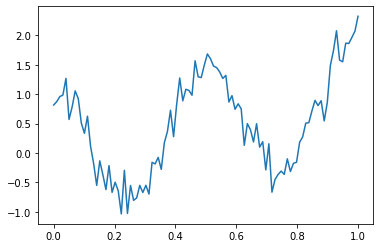

In [24]:
# toy example 1
y =  x + np.cos(4*np.pi*x) + np.random.randn(len(x))*0.2
plt.plot(x,y)

### Use baseline model on Toy Example 1

Average Loss = 104.36: 100%|████████████████████████████████████████████████████| 60000/60000 [01:02<00:00, 954.05it/s]
Finished [100%]: Average Loss = 104.36


probability that the function is increasing= 1.0


1

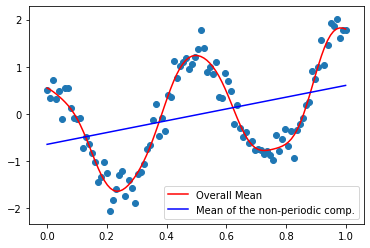

In [9]:
run_model(x,y,plot=True)

### Use GP model using Pymc3 on Toy Example 1

logp = -42.587, ||grad|| = 2.2801: 100%|█████████████████████████████████████████████| 134/134 [00:01<00:00, 82.26it/s]


probability that the function is increasing= 1.0


1

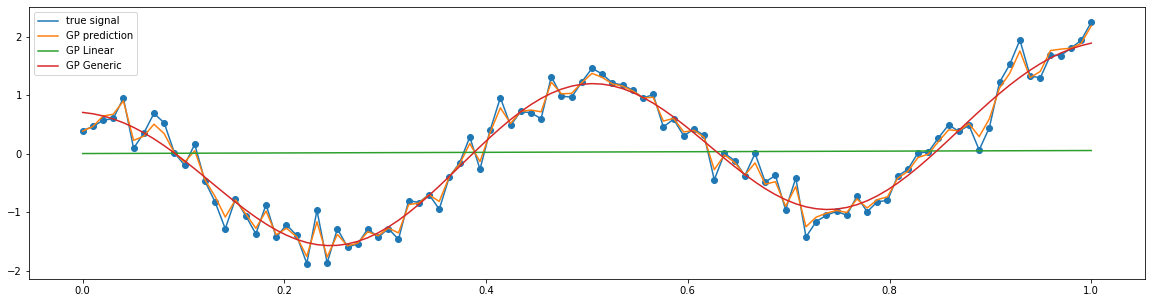

In [25]:
run_model_pymc3(x,y,plot=True)

### Use GP model using GPy on Toy Example 1

1

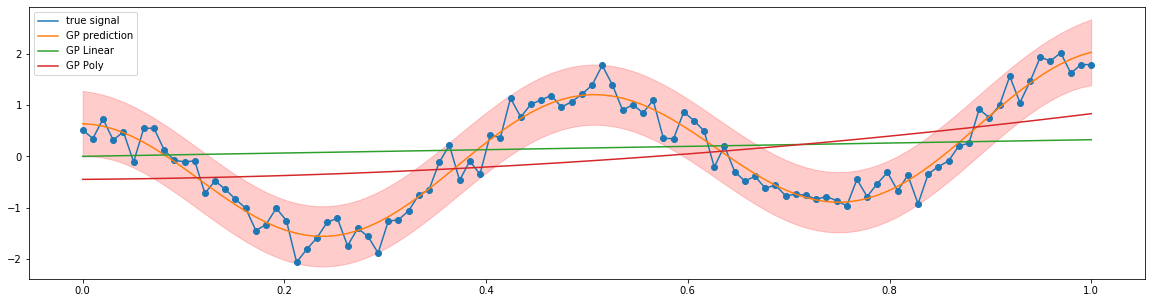

In [12]:
run_model_gpy(x,y,'P', plot=True)

#### It works well in this case :), The PYMC3 and GPy models worked well and found that it is increasing

## Toy Example 2
### In the following example, the  time-series is not increasing and it does not have any seasonality component.

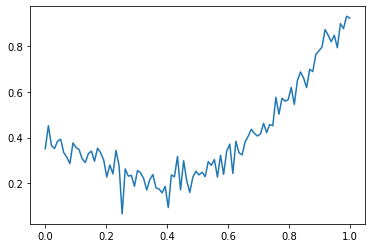

In [13]:
#toy example 2
y =  x/2-2*np.exp(-(x-0.5)**2) + 2 + np.random.randn(len(x))*0.05
plt.plot(x,y)

### Use baseline model on Toy Example 2

Average Loss = 90.567: 100%|███████████████████████████████████████████████████| 60000/60000 [00:55<00:00, 1088.63it/s]
Finished [100%]: Average Loss = 90.557


probability that the function is increasing= 1.0


1

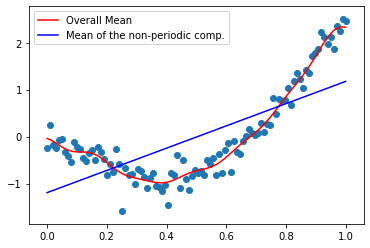

In [14]:
run_model(x,y, plot=True)

#### The above baseline model doesn't work well, the correct answer should be not-increasing. The problem is that the cos/sin base can also fit any non-linear function in [0,1] :(.

### GP model using Pymc3 on Toy Example 2

 C:\Users\gcarty\AppData\Local\Continuum\anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 C:\Users\gcarty\AppData\Local\Continuum\anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning:find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
logp = -11.832, ||grad|| = 0.0030655: 100%|████████████████████████████████████████████| 59/59 [00:00<00:00, 65.67it/s]
 C:\Users\gcarty\AppData\Local\Continuum\anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be

probability that the function is increasing= 0.0


0

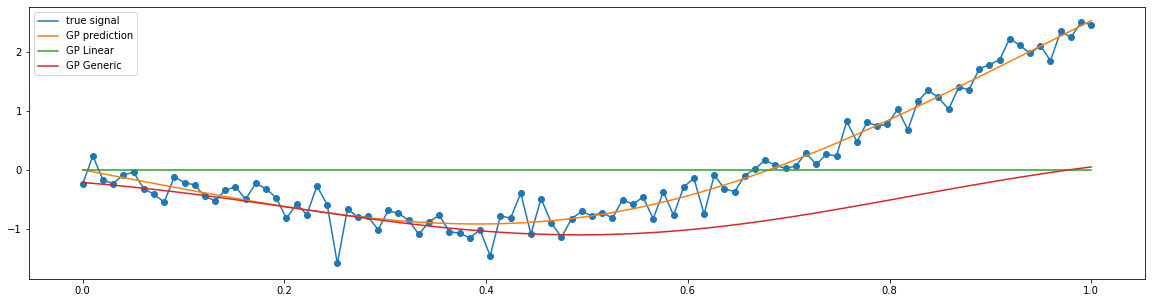

In [15]:
run_model_pymc3(x,y, plot=True)

### GP Regression model using GPy on Toy Example 2

0

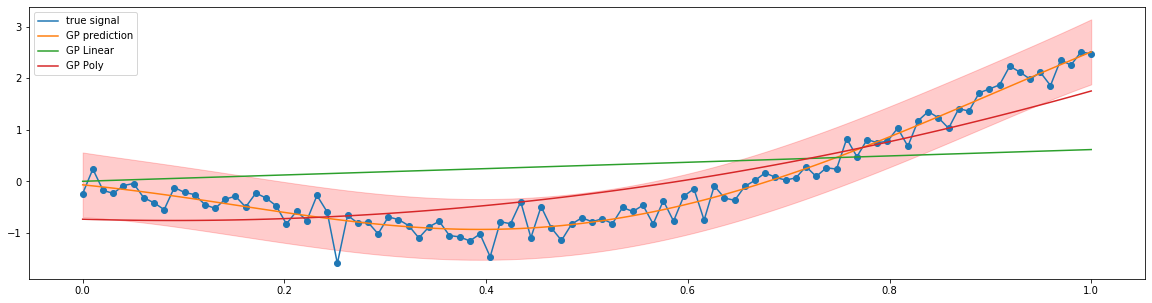

In [16]:
run_model_gpy(x,y,'N', plot=True)

#### The above PYMC3 and GPy models worked well, It found that it is not-increasing. 

## Function to determine if sample is periodic or not

In [17]:
from  statsmodels.tsa.stattools import acf 

def isPeriodic(y):
    result = 0
    for val in acf(y):
        result = result + val
    if result > 5:
        return True
    else:
        return False

## TRAIN WITH GP MODEL using GPy
### CASE 1 Use different model depending on whether sample is periodic or not

In [18]:
# Read in training dataset
x = np.linspace(0,1,100)
train_df = pd.read_csv("train.csv")

success = 0
periodic = ''
Result = []
Decision = pd.DataFrame(columns=['Id','Category'])

# Loop through training dataset
for r in range(train_df.shape[0]):
    try:
        id_row = train_df.iloc[r,0]
        y = train_df.iloc[r,1:-1].values
        true = train_df.iloc[r,-1]

        if isPeriodic(y):
            periodic = 'P'
            decision = run_model_gpy(x,y,periodic)
        else:
            periodic = 'N'
            decision = run_model_gpy(x,y,periodic)
    except ValueError:
        decision = 0
        print("ValueError for Id row:", id_row)
    except np.linalg.LinAlgError:
        decision = 0
        print("LinAlgError for Id row:", id_row)
             
    success = 1 if true == decision else 0
    
    Result.append([id_row, true, decision, success])
    print(id_row, true, decision, periodic)

 C:\Users\gcarty\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning:fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.


120 0 0 N


121 0 0 N


122 0 1 P


123 1 1 P


124 1 1 P


125 1 1 P


126 1 1 P


127 1 1 P


128 0 1 P


129 0 1 P


130 0 1 P


131 0 1 P


132 0 0 N


133 0 0 N


134 0 0 N


135 0 1 P


136 0 0 N


137 0 1 P


138 0 1 P


139 0 0 N


140 0 1 P


141 0 0 N


142 0 1 P


143 1 1 P


144 1 1 P


145 0 0 N


146 0 0 N


147 0 1 P


148 0 0 N


149 0 0 N


150 1 1 P


151 1 1 P


152 1 1 P


153 1 0 N


154 1 1 P


155 0 1 P


156 0 1 P


157 0 1 P


158 0 0 N


159 1 1 P


160 1 1 P


161 1 1 P


162 1 1 P


163 0 0 N


164 0 1 P


165 1 1 P


166 0 0 N


167 0 1 P


168 1 1 P


169 1 1 P


170 0 1 P


171 0 0 N


172 0 1 P


173 1 1 P


174 0 0 N


175 0 0 N


176 1 0 N


177 0 0 N


178 1 1 N


179 0 0 N


180 0 0 N


181 1 1 P


182 1 1 P


183 0 0 N


184 0 0 N


185 0 1 P


186 1 1 N


187 1 1 P


188 0 1 N


189 0 1 P


190 0 0 N


191 0 0 N


192 0 0 N


193 0 0 N


194 0 1 N


### Calculate the training accuracy

In [19]:
res=np.stack(Result)
print('Accuracy = ', (sum(res[:,3]) / len(Result)))

Accuracy =  0.68


### CASE 2 Do not differentiate periodic or non-periodic samples

In [20]:
# Read in training dataset
x = np.linspace(0,1,100)
train_df = pd.read_csv("train.csv")

success = 0
periodic = ''
Result = []
Decision = pd.DataFrame(columns=['Id','Category'])

# Loop through training dataset
for r in range(train_df.shape[0]):
    try:
        id_row = train_df.iloc[r,0]
        y = train_df.iloc[r,1:-1].values
        true = train_df.iloc[r,-1]

        periodic = 'No'
        decision = run_model_gpy(x,y,periodic)
    except ValueError:
        decision = 0
        print("ValueError for Id row:", id_row)
    except np.linalg.LinAlgError:
        decision = 0
        print("LinAlgError for Id row:", id_row)
             
    success = 1 if true == decision else 0
    
    Result.append([id_row, true, decision, success])
    print(id_row, true, decision, periodic)

120 0 0 No


121 0 0 No


122 0 0 No


123 1 0 No


124 1 1 No


125 1 1 No


126 1 0 No


127 1 0 No


128 0 0 No


129 0 0 No


130 0 0 No


131 0 0 No


132 0 0 No


133 0 0 No


134 0 0 No


135 0 0 No


136 0 0 No


137 0 0 No


138 0 0 No


139 0 0 No


140 0 0 No


141 0 0 No


142 0 0 No


143 1 0 No


144 1 0 No


145 0 0 No


146 0 0 No


147 0 0 No


148 0 0 No


149 0 0 No


150 1 1 No


151 1 0 No


152 1 0 No


153 1 0 No


154 1 1 No


155 0 0 No


156 0 0 No


157 0 0 No


158 0 0 No


159 1 1 No


160 1 0 No


161 1 1 No


162 1 0 No


163 0 0 No


164 0 0 No


165 1 0 No


166 0 0 No


167 0 0 No


168 1 0 No


169 1 0 No


170 0 0 No


171 0 0 No


172 0 0 No


173 1 0 No


174 0 0 No


175 0 0 No


176 1 0 No


177 0 0 No


178 1 1 No


179 0 0 No


180 0 0 No


181 1 0 No


182 1 0 No


183 0 0 No


184 0 0 No


185 0 0 No


186 1 1 No


187 1 1 No


188 0 1 No


189 0 0 No


190 0 0 No


191 0 0 No


192 0 0 No


193 0 0 No


194 0 1 No


### Calculate the training accuracy

In [21]:
res=np.stack(Result)
print('Accuracy = ', (sum(res[:,3]) / len(Result)))

Accuracy =  0.7466666666666667


#### Conclusion for Case 1 and Case 2
#### The accuracy improved by not differentiating the samples i.e. By using all the model GPs excluding periodic kernel on all the samples the accuracy improved

## We run it on the test set

In [ ]:
x = np.linspace(0,1,100)
test_df = pd.read_csv("test.csv")


Decision = pd.DataFrame(columns=['Id','Category'])
for r in range(test_df.shape[0]):
    try:
        id_row = test_df.iloc[r,0]
        y = test_df.iloc[r,1:].values

        Periodic = 'No'
        decision = run_model_gpy(x,y,Periodic)
    except ValueError:
        decision = 0
        print("ValueError for Id row:", id_row)
    except np.linalg.LinAlgError:
        decision = 0
        print("LinAlgError for Id row:", id_row)
    
    Decision = Decision.append({'Id': int(id_row), 'Category': int(decision)}, ignore_index=True) 
    print(Decision)
    Decision.to_csv("Decision_baseline.csv",  index=False)

  Id Category
0  0        1


  Id Category
0  0        1
1  1        0


  Id Category
0  0        1
1  1        0
2  2        0


  Id Category
0  0        1
1  1        0
2  2        0
3  3        0


  Id Category
0  0        1
1  1        0
2  2        0
3  3        0
4  4        0


  Id Category
0  0        1
1  1        0
2  2        0
3  3        0
4  4        0
5  5        0


  Id Category
0  0        1
1  1        0
2  2        0
3  3        0
4  4        0
5  5        0
6  6        0


  Id Category
0  0        1
1  1        0
2  2        0
3  3        0
4  4        0
5  5        0
6  6        0
7  7        1


  Id Category
0  0        1
1  1        0
2  2        0
3  3        0
4  4        0
5  5        0
6  6        0
7  7        1
8  8        0


  Id Category
0  0        1
1  1        0
2  2        0
3  3        0
4  4        0
5  5        0
6  6        0
7  7        1
8  8        0
9  9        0


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0
27  27        1


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0
27  27        1
28  28        0


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0
27  27        1
28  28        0
29  29        1


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0
27  27        1
28  28        0
29  29        1
30  30        1


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0
27  27        1
28  28        0
29  29        1
30  30        1
31  31        1


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0
27  27        1
28  28        0
29  29        1
30  30        1
31  31        1
32  32        1


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0
27  27        1
28  28        0
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0
27  27        1
28  28        0
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0
27  27        1
28  28        0
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0
27  27        1
28  28        0
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        0


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0
27  27        1
28  28        0
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        0
37  37        1


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0
27  27        1
28  28        0
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        0
37  37        1
38  38        0


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0
27  27        1
28  28        0
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        0
37  37        1
38  38        0
39  39        1


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0
27  27        1
28  28        0
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        0
37  37        1
38  38        0
39  39        1
40  40        1


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0
27  27        1
28  28        0
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        0
37  37        1
38  38        0
39  39        1
40  40        1
41  41        1


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0
27  27        1
28  28        0
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        0
37  37        1
38  38        0
39  39        1
40  40        1
41  41        1
42  42        0


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0
27  27        1
28  28        0
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        0
37  37        1
38  38        0
39  39        1
40  40        1
41  41        1
42  42        0
43  43        0


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0
27  27        1
28  28        0
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        0
37  37        1
38  38        0
39  39        1
40  40        1
41  41        1
42  42        0
43  43        0
44  44        0


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0
27  27        1
28  28        0
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        0
37  37        1
38  38        0
39  39        1
40  40        1
41  41        1
42  42        0
43  43        0
44  44        0
45  45        0


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0
27  27        1
28  28        0
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        0
37  37        1
38  38        0
39  39        1
40  40        1
41  41        1
42  42        0
43  43        0
44  44        0
45  45        0
46  46        0


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0
27  27        1
28  28        0
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        0
37  37        1
38  38        0
39  39        1
40  40        1
41  41        1
42  42        0
43  43        0
44  44        0
45  45        0
46  46        0
47  47        0


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0
27  27        1
28  28        0
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        0
37  37        1
38  38        0
39  39        1
40  40        1
41  41        1
42  42        0
43  43        0
44  44        0
45  45        0
46  46        0
47  47        0
48  48        1


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0
27  27        1
28  28        0
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        0
37  37        1
38  38        0
39  39        1
40  40        1
41  41        1
42  42        0
43  43        0
44  44        0
45  45        0
46  46        0
47  47        0
48  48        1
49  49        1


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0
27  27        1
28  28        0
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        0
37  37        1
38  38        0
39  39        1
40  40        1
41  41        1
42  42        0
43  43        0
44  44        0
45  45        0
46  46        0
47  47        0
48  48        1
49  49        1
50  50        0


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0
27  27        1
28  28        0
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        0
37  37        1
38  38        0
39  39        1
40  40        1
41  41        1
42  42        0
43  43        0
44  44        0
45  45        0
46  46        0
47  47        0
48  48        1
49  49        1
50  50        0
51  51        0


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0
27  27        1
28  28        0
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        0
37  37        1
38  38        0
39  39        1
40  40        1
41  41        1
42  42        0
43  43        0
44  44        0
45  45        0
46  46        0
47  47        0
48  48        1
49  49        1
50  50        0
51  51        0
52  52        0


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0
27  27        1
28  28        0
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        0
37  37        1
38  38        0
39  39        1
40  40        1
41  41        1
42  42        0
43  43        0
44  44        0
45  45        0
46  46        0
47  47        0
48  48        1
49  49        1
50  50        0
51  51        0
52  52        0
53  53        1


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0
27  27        1
28  28        0
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        0
37  37        1
38  38        0
39  39        1
40  40        1
41  41        1
42  42        0
43  43        0
44  44        0
45  45        0
46  46        0
47  47        0
48  48        1
49  49        1
50  50        0
51  51        0
52  52        0
53  53        1
54  54        0


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0
27  27        1
28  28        0
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        0
37  37        1
38  38        0
39  39        1
40  40        1
41  41        1
42  42        0
43  43        0
44  44        0
45  45        0
46  46        0
47  47        0
48  48        1
49  49        1
50  50        0
51  51        0
52  52        0
53  53        1
54  54        0
55  55        0


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0
27  27        1
28  28        0
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        0
37  37        1
38  38        0
39  39        1
40  40        1
41  41        1
42  42        0
43  43        0
44  44        0
45  45        0
46  46        0
47  47        0
48  48        1
49  49        1
50  50        0
51  51        0
52  52        0
53  53        1
54  54        0
55  55        0
56  56        0


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0
27  27        1
28  28        0
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        0
37  37        1
38  38        0
39  39        1
40  40        1
41  41        1
42  42        0
43  43        0
44  44        0
45  45        0
46  46        0
47  47        0
48  48        1
49  49        1
50  50        0
51  51        0
52  52        0
53  53        1
54  54        0
55  55        0
56  56        0
57  57        0


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0
27  27        1
28  28        0
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        0
37  37        1
38  38        0
39  39        1
40  40        1
41  41        1
42  42        0
43  43        0
44  44        0
45  45        0
46  46        0
47  47        0
48  48        1
49  49        1
50  50        0
51  51        0
52  52        0
53  53        1
54  54        0
55  55        0
56  56        0
57  57        0
58  58        0


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
5    5        0
6    6        0
7    7        1
8    8        0
9    9        0
10  10        0
11  11        1
12  12        0
13  13        0
14  14        0
15  15        1
16  16        1
17  17        0
18  18        0
19  19        1
20  20        0
21  21        0
22  22        0
23  23        0
24  24        0
25  25        0
26  26        0
27  27        1
28  28        0
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        0
37  37        1
38  38        0
39  39        1
40  40        1
41  41        1
42  42        0
43  43        0
44  44        0
45  45        0
46  46        0
47  47        0
48  48        1
49  49        1
50  50        0
51  51        0
52  52        0
53  53        1
54  54        0
55  55        0
56  56        0
57  57        0
58  58        0
59  59        0


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
..  ..      ...
56  56        0
57  57        0
58  58        0
59  59        0
60  60        1

[61 rows x 2 columns]


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
..  ..      ...
57  57        0
58  58        0
59  59        0
60  60        1
61  61        0

[62 rows x 2 columns]


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
..  ..      ...
58  58        0
59  59        0
60  60        1
61  61        0
62  62        0

[63 rows x 2 columns]


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
..  ..      ...
59  59        0
60  60        1
61  61        0
62  62        0
63  63        1

[64 rows x 2 columns]


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
..  ..      ...
60  60        1
61  61        0
62  62        0
63  63        1
64  64        1

[65 rows x 2 columns]


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
..  ..      ...
61  61        0
62  62        0
63  63        1
64  64        1
65  65        0

[66 rows x 2 columns]


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
..  ..      ...
62  62        0
63  63        1
64  64        1
65  65        0
66  66        0

[67 rows x 2 columns]


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
..  ..      ...
63  63        1
64  64        1
65  65        0
66  66        0
67  67        0

[68 rows x 2 columns]


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
..  ..      ...
64  64        1
65  65        0
66  66        0
67  67        0
68  68        0

[69 rows x 2 columns]


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
..  ..      ...
65  65        0
66  66        0
67  67        0
68  68        0
69  69        0

[70 rows x 2 columns]


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
..  ..      ...
66  66        0
67  67        0
68  68        0
69  69        0
70  70        0

[71 rows x 2 columns]


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
..  ..      ...
67  67        0
68  68        0
69  69        0
70  70        0
71  71        1

[72 rows x 2 columns]


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
..  ..      ...
68  68        0
69  69        0
70  70        0
71  71        1
72  72        0

[73 rows x 2 columns]


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
..  ..      ...
69  69        0
70  70        0
71  71        1
72  72        0
73  73        0

[74 rows x 2 columns]


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
..  ..      ...
70  70        0
71  71        1
72  72        0
73  73        0
74  74        0

[75 rows x 2 columns]


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
..  ..      ...
71  71        1
72  72        0
73  73        0
74  74        0
75  75        0

[76 rows x 2 columns]


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
..  ..      ...
72  72        0
73  73        0
74  74        0
75  75        0
76  76        0

[77 rows x 2 columns]


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
..  ..      ...
73  73        0
74  74        0
75  75        0
76  76        0
77  77        0

[78 rows x 2 columns]


    Id Category
0    0        1
1    1        0
2    2        0
3    3        0
4    4        0
..  ..      ...
74  74        0
75  75        0
76  76        0
77  77        0
78  78        0

[79 rows x 2 columns]
